# House Price Predictor

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# -----------------------------
# 1. Load the dataset
# -----------------------------
# Replace 'house_prices.csv' with the path to your dataset.
data = pd.read_csv('train.csv')
#data

In [3]:
# -----------------------------
# 2. Data Cleaning
# -----------------------------
# Select only numeric columns that have no missing data.
numeric_cols = data.select_dtypes(include=[np.number]).columns
clean_numeric_cols = [col for col in numeric_cols if data[col].isna().sum() == 0]
data_clean = data[clean_numeric_cols]

# Ensure that the target column 'price' is present.
if 'SalePrice' not in data_clean.columns:
    raise ValueError("The target column 'price' is not present in the complete numeric data.")

In [4]:
# -----------------------------
# 3. Feature Selection
# -----------------------------
# Compute the correlation matrix using only the cleaned numeric data.
corr_matrix = data_clean.corr()

# Compute absolute correlations of features with the target and drop the target itself.
target_corr = corr_matrix['SalePrice'].drop('SalePrice').abs().sort_values(ascending=False)

# Select only the top 4 features with the highest correlation with 'SalesPrice'
top4_features = target_corr.head(4).index
print("Selected top 4 features:", list(top4_features))

# Define input features (X) and target variable (y).
X = data_clean[top4_features].values
y = data_clean['SalePrice'].values.reshape(-1, 1)

Selected top 4 features: ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea']


In [5]:
# -----------------------------
# 4. Data Preprocessing
# -----------------------------
# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features to improve training stability.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# Convert the numpy arrays to PyTorch tensors.
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create a TensorDataset and DataLoader for batch processing.
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [66]:
import torch.nn.functional as F

class HousePriceModel(nn.Module):
    def __init__(self, input_dim):
        super(HousePriceModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, 1)  # Output layer for regression
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.fc3(x)
        return x

In [67]:
# -----------------------------
# 6. Set Up Loss Function, Optimizer, and Learning Rate Scheduler
# -----------------------------
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Scheduler: Decay LR by 10% every 10 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

# -----------------------------
# 7. Train the Model
# -----------------------------
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_X.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    # Step the scheduler at the end of each epoch
    scheduler.step()
    
    if (epoch + 1) % 10 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, LR: {current_lr:.6f}")


Epoch [10/1000], Loss: 0.1060, LR: 0.000900
Epoch [20/1000], Loss: 0.0834, LR: 0.000810
Epoch [30/1000], Loss: 0.0985, LR: 0.000729
Epoch [40/1000], Loss: 0.1000, LR: 0.000656
Epoch [50/1000], Loss: 0.0666, LR: 0.000590
Epoch [60/1000], Loss: 0.0793, LR: 0.000531
Epoch [70/1000], Loss: 0.0663, LR: 0.000478
Epoch [80/1000], Loss: 0.0788, LR: 0.000430
Epoch [90/1000], Loss: 0.0755, LR: 0.000387
Epoch [100/1000], Loss: 0.0551, LR: 0.000349
Epoch [110/1000], Loss: 0.0641, LR: 0.000314
Epoch [120/1000], Loss: 0.0593, LR: 0.000282
Epoch [130/1000], Loss: 0.0570, LR: 0.000254
Epoch [140/1000], Loss: 0.0616, LR: 0.000229
Epoch [150/1000], Loss: 0.0564, LR: 0.000206
Epoch [160/1000], Loss: 0.0546, LR: 0.000185
Epoch [170/1000], Loss: 0.0561, LR: 0.000167
Epoch [180/1000], Loss: 0.0567, LR: 0.000150
Epoch [190/1000], Loss: 0.0625, LR: 0.000135
Epoch [200/1000], Loss: 0.0522, LR: 0.000122
Epoch [210/1000], Loss: 0.0530, LR: 0.000109
Epoch [220/1000], Loss: 0.0549, LR: 0.000098
Epoch [230/1000], L

In [69]:
# 8. Evaluate the Model
# -----------------------------
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor.to(device))
    test_loss = criterion(predictions, y_test_tensor.to(device)).item()
    print("Test Mean Squared Error:", test_loss)

# Optionally, to evaluate using scikit-learn's MSE:
predictions_np = predictions.cpu().numpy()
mse = mean_squared_error(y_test, predictions_np)
print("Test MSE (scikit-learn):", mse)
#Test Mean Squared Error: 935741376.0
#Test Mean Squared Error: 890287168.0
#Test MSE (scikit-learn): 890287040.0

Test Mean Squared Error: 0.06559764593839645
Test MSE (scikit-learn): 0.06559767216454084


In [71]:
model.eval()
with torch.no_grad():
    train_predictions = model(X_train_tensor.to(device))
    train_loss = criterion(train_predictions, y_train_tensor.to(device)).item()
    train_rmse = np.sqrt(train_loss)
    print("Training RMSE:", train_rmse)

rmse = np.sqrt(test_loss)
print(f"Test RMSE: {rmse}")

#RESULT: Training RMSE: 28463.821247330794
#Test RMSE: 29480.813014569325

Training RMSE: 0.19775629866294928
Test RMSE: 0.2561203739228811


/tmp/ipykernel_9603/3042700335.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  errors = np.abs(predictions - y_test)


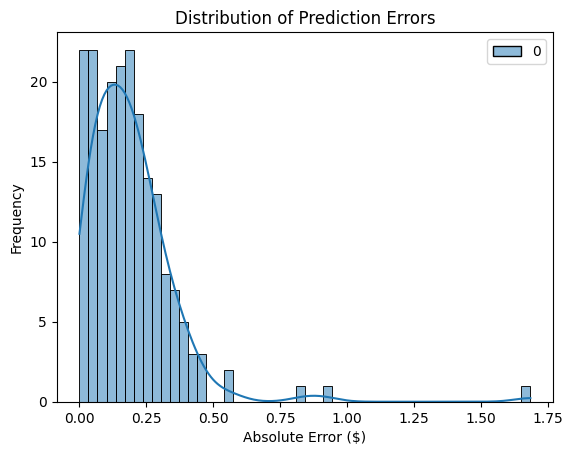

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

errors = np.abs(predictions - y_test)
sns.histplot(errors, bins=50, kde=True)
plt.xlabel("Absolute Error ($)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()

In [73]:
# -----------------------------
# 9. Generate Predictions on New Test Data (test.csv)
# -----------------------------
# Load the new test data
test_data = pd.read_csv('test.csv')

# Ensure the test data contains the ID column and the same top4_features.
# For this example, assume the test file contains an "ID" column.
if 'Id' not in test_data.columns:
    raise ValueError("The test data must contain an 'ID' column.")

# It's assumed that the test data has at least the columns used in training.
# Use the same top4_features determined from the training set.
X_new = test_data[top4_features].values

# Apply the same scaling transformation using the previously fitted scaler.
X_new_scaled = scaler.transform(X_new)

# Convert to PyTorch tensor.
X_new_tensor = torch.tensor(X_new_scaled, dtype=torch.float32).to(device)

# Put the model in evaluation mode and generate predictions.
model.eval()
with torch.no_grad():
    new_predictions = model(X_new_tensor)
    
# Convert predictions to numpy array and flatten if necessary.
new_predictions_np = new_predictions.cpu().numpy().flatten()

# Create a DataFrame with IDs and their corresponding predicted sale prices.
predictions_df = pd.DataFrame({
    'ID': test_data['Id'],
    'SalePrice': new_predictions_np
})

# Save the DataFrame to a CSV file.
predictions_df.to_csv('predictions.csv', index=False)
print("Predictions saved to predictions.csv")


Predictions saved to predictions.csv


In [61]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader

# -----------------------------
# 1. Load and Prepare the Data
# -----------------------------
data = pd.read_csv('train.csv')

# -----------------------------
# 2. Data Cleaning
# -----------------------------
numeric_cols = data.select_dtypes(include=[np.number]).columns
clean_numeric_cols = [col for col in numeric_cols if data[col].isna().sum() == 0]
data_clean = data[clean_numeric_cols]

if 'SalePrice' not in data_clean.columns:
    raise ValueError("The target column 'SalePrice' is not present in the data.")

# -----------------------------
# 3. Feature Selection and Target Transformation
# -----------------------------
# Compute correlation matrix and select top 4 features by absolute correlation with SalePrice.
corr_matrix = data_clean.corr()
target_corr = corr_matrix['SalePrice'].drop('SalePrice').abs().sort_values(ascending=False)
top4_features = target_corr.head(4).index.tolist()
print("Selected top 4 features:", top4_features)

X = data_clean[top4_features].values

# Apply a log transformation to the target
y = np.log(data_clean['SalePrice'].values.reshape(-1, 1))

# -----------------------------
# 4. Data Preprocessing
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# -----------------------------
# 5. Define a Simplified Neural Network Model
# -----------------------------
class LogPriceHousePriceModel(nn.Module):
    def __init__(self, input_dim):
        super(LogPriceHousePriceModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.fc3 = nn.Linear(64, 1)  # Predicting log(SalePrice)
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.fc3(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LogPriceHousePriceModel(input_dim=X_train.shape[1]).to(device)

# -----------------------------
# 6. Set Up Loss Function and Optimizer
# -----------------------------
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, verbose=True)

# -----------------------------
# 7. Train the Model (1000 epochs)
# -----------------------------
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_X.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    scheduler.step(epoch_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# -----------------------------
# 8. Evaluate the Model on Original Scale
# -----------------------------
model.eval()
with torch.no_grad():
    log_predictions = model(X_test_tensor.to(device))
    # Compute test loss on log scale
    test_loss = criterion(log_predictions, y_test_tensor.to(device)).item()
    
    # Convert predictions back to original scale by exponentiating
    predictions = torch.exp(log_predictions).cpu().numpy()
    y_test_orig = np.exp(y_test)
    
    test_rmse = np.sqrt(mean_squared_error(y_test_orig, predictions))
    print("Test RMSE on original scale:", test_rmse)


Selected top 4 features: ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea']


/home/codespace/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/1000], Loss: 12.9142
Epoch [20/1000], Loss: 0.3353
Epoch [30/1000], Loss: 0.3849
Epoch [40/1000], Loss: 0.2801
Epoch [50/1000], Loss: 0.2218
Epoch [60/1000], Loss: 0.1865
Epoch [70/1000], Loss: 0.1997
Epoch [80/1000], Loss: 0.1942
Epoch [90/1000], Loss: 0.1637
Epoch [100/1000], Loss: 0.1652
Epoch [110/1000], Loss: 0.1842
Epoch [120/1000], Loss: 0.1266
Epoch [130/1000], Loss: 0.1170
Epoch [140/1000], Loss: 0.1347
Epoch [150/1000], Loss: 0.1232
Epoch [160/1000], Loss: 0.1275
Epoch [170/1000], Loss: 0.1304
Epoch [180/1000], Loss: 0.1215
Epoch [190/1000], Loss: 0.1184
Epoch [200/1000], Loss: 0.0961
Epoch [210/1000], Loss: 0.1036
Epoch [220/1000], Loss: 0.0890
Epoch [230/1000], Loss: 0.0832
Epoch [240/1000], Loss: 0.0841
Epoch [250/1000], Loss: 0.0952
Epoch [260/1000], Loss: 0.0752
Epoch [270/1000], Loss: 0.0848
Epoch [280/1000], Loss: 0.0717
Epoch [290/1000], Loss: 0.0806
Epoch [300/1000], Loss: 0.0749
Epoch [310/1000], Loss: 0.0814
Epoch [320/1000], Loss: 0.0852
Epoch [330/1000]

In [64]:
with torch.no_grad():
    train_predictions = model(X_train_tensor.to(device))
    train_loss = criterion(train_predictions, y_train_tensor.to(device)).item()
    train_rmse = np.sqrt(train_loss)
    print("Training RMSE:", train_rmse)

Training RMSE: 0.21355211224633383


In [65]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader

# -----------------------------
# 1. Load and Prepare the Data
# -----------------------------
data = pd.read_csv('train.csv')

# -----------------------------
# 2. Data Cleaning
# -----------------------------
numeric_cols = data.select_dtypes(include=[np.number]).columns
clean_numeric_cols = [col for col in numeric_cols if data[col].isna().sum() == 0]
data_clean = data[clean_numeric_cols]

if 'SalePrice' not in data_clean.columns:
    raise ValueError("The target column 'SalePrice' is not present in the data.")

# -----------------------------
# 3. Feature Selection and Target Transformation
# -----------------------------
# Compute correlation matrix and select top 4 features by absolute correlation with SalePrice.
corr_matrix = data_clean.corr()
target_corr = corr_matrix['SalePrice'].drop('SalePrice').abs().sort_values(ascending=False)
top4_features = target_corr.head(4).index.tolist()
print("Selected top 4 features:", top4_features)

X = data_clean[top4_features].values

# Apply a log transformation to the target
y = np.log(data_clean['SalePrice'].values.reshape(-1, 1))

# -----------------------------
# 4. Data Preprocessing
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# -----------------------------
# 5. Define a Simplified Neural Network Model
# -----------------------------
class LogPriceHousePriceModel(nn.Module):
    def __init__(self, input_dim):
        super(LogPriceHousePriceModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.fc3 = nn.Linear(64, 1)  # Predicting log(SalePrice)
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.fc3(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LogPriceHousePriceModel(input_dim=X_train.shape[1]).to(device)

# -----------------------------
# 6. Set Up Loss Function, Optimizer, and Scheduler
# -----------------------------
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, verbose=True)

# -----------------------------
# 7. Train the Model (1000 epochs)
# -----------------------------
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_X.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    scheduler.step(epoch_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# -----------------------------
# 8. Evaluate the Model on Original Scale
# -----------------------------
model.eval()
with torch.no_grad():
    # Evaluate on Test Data
    log_predictions_test = model(X_test_tensor.to(device))
    test_loss = criterion(log_predictions_test, y_test_tensor.to(device)).item()
    predictions_test = torch.exp(log_predictions_test).cpu().numpy()
    y_test_orig = np.exp(y_test)
    test_rmse = np.sqrt(mean_squared_error(y_test_orig, predictions_test))
    print("Test RMSE on original scale:", test_rmse)
    
    # Evaluate on Training Data
    log_predictions_train = model(X_train_tensor.to(device))
    train_loss = criterion(log_predictions_train, y_train_tensor.to(device)).item()
    predictions_train = torch.exp(log_predictions_train).cpu().numpy()
    y_train_orig = np.exp(y_train)
    train_rmse = np.sqrt(mean_squared_error(y_train_orig, predictions_train))
    print("Training RMSE on original scale:", train_rmse)


Selected top 4 features: ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea']


/home/codespace/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/1000], Loss: 11.1307
Epoch [20/1000], Loss: 0.3696
Epoch [30/1000], Loss: 0.3029
Epoch [40/1000], Loss: 0.2911
Epoch [50/1000], Loss: 0.2976
Epoch [60/1000], Loss: 0.1913
Epoch [70/1000], Loss: 0.1877
Epoch [80/1000], Loss: 0.1688
Epoch [90/1000], Loss: 0.1683
Epoch [100/1000], Loss: 0.2043
Epoch [110/1000], Loss: 0.1932
Epoch [120/1000], Loss: 0.1565
Epoch [130/1000], Loss: 0.1478
Epoch [140/1000], Loss: 0.1651
Epoch [150/1000], Loss: 0.1244
Epoch [160/1000], Loss: 0.1562
Epoch [170/1000], Loss: 0.1447
Epoch [180/1000], Loss: 0.1085
Epoch [190/1000], Loss: 0.1019
Epoch [200/1000], Loss: 0.1667
Epoch [210/1000], Loss: 0.0897
Epoch [220/1000], Loss: 0.0869
Epoch [230/1000], Loss: 0.1007
Epoch [240/1000], Loss: 0.0821
Epoch [250/1000], Loss: 0.0746
Epoch [260/1000], Loss: 0.0755
Epoch [270/1000], Loss: 0.0818
Epoch [280/1000], Loss: 0.0795
Epoch [290/1000], Loss: 0.0650
Epoch [300/1000], Loss: 0.0679
Epoch [310/1000], Loss: 0.0707
Epoch [320/1000], Loss: 0.0756
Epoch [330/1000]